# Import Libraries

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Download Data

In [2]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()

In [3]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


# Plot Examples

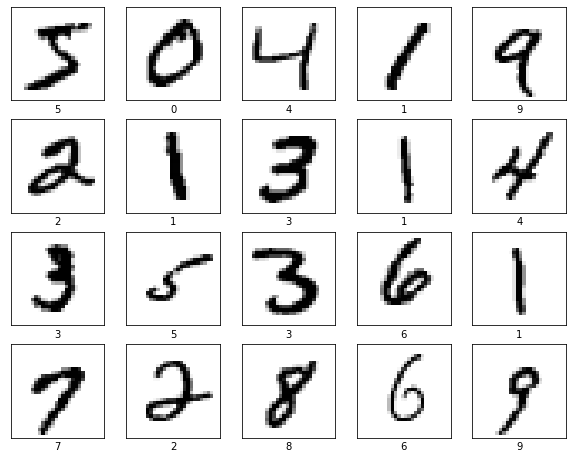

In [4]:
plt.figure(figsize=(10,10))
for i in range(0,20):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i],cmap="binary")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(str(y_train[i]))
plt.show()    

# Normalize Data

In [5]:

#vectorizing the images in 28*28 1D vector
x_train=x_train.reshape((60000,28*28))
x_test=x_test.reshape((10000,28*28))


In [6]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [7]:
#as each image is a vector having pixel range (0,255)
#to fast the process we are normalizing the each pixel to between (0,1)
x_train=x_train/255
x_test=x_test/255

In [8]:
x_train.shape

(60000, 784)

# Create a Neural Network Model

In [9]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(32,activation="sigmoid",input_shape=(784,)),
    tf.keras.layers.Dense(32,activation="sigmoid"),
    tf.keras.layers.Dense(10,activation="softmax")
])
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]

)

# Train the Model

In [10]:
_=model.fit(
           x_train,y_train,
           validation_data=(x_test,y_test),
           epochs=30,batch_size=548
           )

Epoch 1/30
110/110 [==============================] - 1s 8ms/step - loss: 1.9692 - accuracy: 0.5398 - val_loss: 1.5659 - val_accuracy: 0.6974
Epoch 2/30
110/110 [==============================] - 1s 7ms/step - loss: 1.2497 - accuracy: 0.7517 - val_loss: 0.9816 - val_accuracy: 0.8030
Epoch 3/30
110/110 [==============================] - 1s 7ms/step - loss: 0.8240 - accuracy: 0.8383 - val_loss: 0.6785 - val_accuracy: 0.8772
Epoch 4/30
110/110 [==============================] - 1s 7ms/step - loss: 0.5919 - accuracy: 0.8838 - val_loss: 0.5050 - val_accuracy: 0.9000
Epoch 5/30
110/110 [==============================] - 1s 7ms/step - loss: 0.4587 - accuracy: 0.9014 - val_loss: 0.4091 - val_accuracy: 0.9086
Epoch 6/30
110/110 [==============================] - 1s 7ms/step - loss: 0.3827 - accuracy: 0.9103 - val_loss: 0.3513 - val_accuracy: 0.9152
Epoch 7/30
110/110 [==============================] - 1s 7ms/step - loss: 0.3356 - accuracy: 0.9175 - val_loss: 0.3147 - val_accuracy: 0.9209
Epoch 

# Save the Model

In [11]:
model.save("model.h5")

# ML Server

In [14]:
%%writefile ml_server.py

import json
import numpy as np
import random
from flask import Flask,request
import tensorflow as tf


app=Flask(__name__)

model=tf.keras.models.load_model("model.h5")
#using keras api to show output of all layers
feature_model=tf.keras.models.Model(model.inputs,
                    [layer.output for layer in model.layers])

_,(x_test,_)=tf.keras.datasets.mnist.load_data()

x_test=x_test/255

def get_prediction():
    index=np.random.choice(x_test.shape[0])
    image=x_test[index,:,:]
    image_arr=np.reshape(image,(1,784))
    return feature_model.predict(image_arr),image

@app.route("/",methods=["GET","POST"])

def index():
    if request.method=="POST":
        preds,image=get_prediction()
        final_prediction=[p.tolist() for p in preds]# returning json obj
        return json.dumps({
        
        "prediction": final_prediction,
        "image": image.tolist()
    })
    return "welcome to server"

if __name__=="__main__":
    app.run()

Overwriting ml_server.py


# Streamlit Web App

In [18]:
%%writefile app.py
import streamlit as st
import json
import requests
import matplotlib.pyplot as plt
import numpy as np

URI= "http://127.0.0.1:5000"

st.title("Neural network visualizer")
st.sidebar.markdown("##input image")

if st.button("get random prediction"):
    response=requests.post(URI,data={})
    response=json.loads(response.text)
    preds=response.get("prediction")
    image=response.get("image")
    image=np.reshape(image,(28,28))
    
    st.sidebar.image(image,width=150)
    
    for layer ,p in enumerate(preds):
        numbers=np.squeeze(np.array(p))
        plt.figure(figsize=(32,4))
        
        if layer==2:
            row=1
            col=10
        else:
            row=2
            col=16
            
        for i,number in enumerate(numbers):
            plt.subplot(row,col,i+1)
            plt.imshow(number*np.ones(8,8,3).astype("float32"))
            plt.xticks([])
            plt.yticks([])
            
        if layer==2:
            plt.xlabel(str(i),fontsize=40)
        plt.subplots_adjust(wspace=0.05,hspace=0.05)
        plt.tight_layout()
        st.text(f"Layer {layer+1}")
        st.pyplot()
            

Overwriting app.py
